# Lab6: Trajectory Tracking


In this lab, we will explore trajectory tracking control using a nonlinear vehicle steering system. The objective is to design controllers that enable the vehicle to follow a desired trajectory, focusing on both constant gain and gain-scheduled state feedback approaches.

The lab is organized as follows:

- **Task 1:** Design a state feedback controller with a constant gain, computed around a nominal forward speed. Analyze the closed-loop performance for different speeds and observe the limitations of using a fixed gain for trajectory tracking.
- **Task 2:** Develop a gain-scheduled controller by linearizing the system at multiple operating points (different speeds and headings). Interpolate the feedback gains based on the current operating condition to improve tracking performance across a range of speeds.

We will use the following controller structure:

$$
u = u_\text{d} - K(\mu) (x - x_\text{d}),
$$

where $x_\text{d}, u_\text{d}$ are the desired state and input trajectories, and $\mu$ represents the scheduling variables (such as speed and heading).

By the end of this lab, you will understand the benefits and challenges of both constant gain and gain-scheduled controllers for nonlinear trajectory tracking.

In [ ]:
# Import the packages needed for the examples included in this notebook
import numpy as np
import matplotlib.pyplot as plt
import itertools
from cmath import sqrt
from math import pi
try:
  import control as ctl
  print("python-control", ctl.__version__)
except ImportError:
  !pip install control
  import control as ctl
import control.optimal as opt


python-control 0.10.2


## Vehicle Steering Dynamics

We consider a simplified vehicle as follows:

<img src="https://fbswiki.org/wiki/images/5/52/Kincar.png" width=480>

The vehicle dynamics can modeled as:
$$\begin{aligned}
  \dot x &= \cos\theta\, v \\
  \dot y &= \sin\theta\, v \\
  \dot\theta &= \frac{v}{l} \tan \delta
\end{aligned}$$

We take the state of the system as $(x, y, \theta)$ where $(x, y)$ is the position of the vehicle in the plane and $\theta$ is the angle of the vehicle with respect to horizontal.  The vehicle input is given by $(v, \delta)$ where $v$ is the forward velocity of the vehicle and $\delta$ is the angle of the steering wheel.  The model includes saturation of the vehicle steering angle.

We first create the dynamics model for vehicle steering:

In [ ]:

# Function to compute the RHS of the system dynamics
def kincar_update(t, x, u, params):
    # Get the parameters for the model
    l = params['wheelbase']             # vehicle wheelbase
    deltamax = params['maxsteer']       # max steering angle (rad)

    # Saturate the steering input,
    # the steering angle will be between -deltamax and deltamax
    delta = np.clip(u[1], -deltamax, deltamax)

    # Return the derivative of the state
    return np.array([
        np.cos(x[2]) * u[0],            # xdot = cos(theta) v
        np.sin(x[2]) * u[0],            # ydot = sin(theta) v
        (u[0] / l) * np.tan(delta)      # thdot = v/l tan(delta)
    ])

kincar_params={'wheelbase': 3, 'maxsteer': 0.5}

# Create a nonlinear input/output system
kincar = ctl.nlsys(
    kincar_update, None, name="kincar", params=kincar_params,
    inputs=('v', 'delta'), outputs=('x', 'y', 'theta'),
    states=('x', 'y', 'theta'))

We then create a function that will be used later for plotting the lane change manuever.

In [ ]:
# Utility function to plot lane change manuever
# t: time vector
# y: state trajectory
def plot_lanechange(t, y, u, figure=None, yf=None, label=None):
    # Plot the xy trajectory
    plt.subplot(3, 1, 1, label='xy')
    plt.plot(y[0], y[1], label=label)
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    if yf is not None: # if final point is given, plot it
        plt.plot(yf[0], yf[1], 'ro')

    # Plot x and y as functions of time
    plt.subplot(3, 2, 3, label='x')
    plt.plot(t, y[0])
    plt.ylabel("$x$ [m]")

    plt.subplot(3, 2, 4, label='y')
    plt.plot(t, y[1])
    plt.ylabel("$y$ [m]")

    # Plot the inputs as a function of time
    plt.subplot(3, 2, 5, label='v')
    plt.plot(t, u[0])
    plt.xlabel("Time $t$ [sec]")
    plt.ylabel("$v$ [m/s]")

    plt.subplot(3, 2, 6, label='delta')
    plt.plot(t, u[1])
    plt.xlabel("Time $t$ [sec]")
    plt.ylabel("$\\delta$ [rad]")

    plt.subplot(3, 1, 1)
    plt.title("Lane change manuever")
    if label:
        plt.legend()
    plt.tight_layout()

## Task 1: State feedback controller with a constant gain

We start by designing a state feedback controller that can be used to stabilize the system.  We design the controller around a nominal forward speed of 10 m/s, but we apply this to the vehicle at different speeds.

In [ ]:
# Compute the linearization of the dynamics at a nominal point

# nominal position and heading
x_nom = np.array([0, 0, 0])
# nominal velocity and 0 steering angle, v can be any constant as long as delta=0, why?
u_nom = np.array([10, 0])
# Linearize around this operating point
P = ctl.linearize(kincar, x_nom, u_nom)
print(P)

Qx = np.diag([1, 10, 0.1]) # we care about y position more than x position, which is more than theta
Qu = np.diag([1, 1]) # we care equally about v and delta inputs
K, _, _ = ctl.lqr(P.A, P.B, Qx, Qu)
print(K)

<StateSpace>: sys[15]
Inputs (2): ['u[0]', 'u[1]']
Outputs (3): ['y[0]', 'y[1]', 'y[2]']
States (3): ['x[0]', 'x[1]', 'x[2]']

A = [[ 0.0000000e+00  0.0000000e+00 -5.0004445e-06]
     [ 0.0000000e+00  0.0000000e+00  1.0000000e+01]
     [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]]

B = [[1.         0.        ]
     [0.         0.        ]
     [0.         3.33333333]]

C = [[1. 0. 0.]
     [0. 1. 0.]
     [0. 0. 1.]]

D = [[0. 0.]
     [0. 0.]
     [0. 0.]]
[[ 1.00000000e+00  4.35732785e-07 -4.13372420e-08]
 [-1.37790807e-07  3.16227766e+00  4.36734083e+00]]


We will then create the closed loop system using the `control.create_statefbk_iosystem` function, which constructs a closed-loop nonlinear input/output system using state feedback. This function allows you to specify feedback gains and scheduling variables for gain-scheduled controllers. For more details, see the [python-control documentation](https://python-control.readthedocs.io/en/0.10.2/generated/control.create_statefbk_iosystem.html#control.create_statefbk_iosystem).

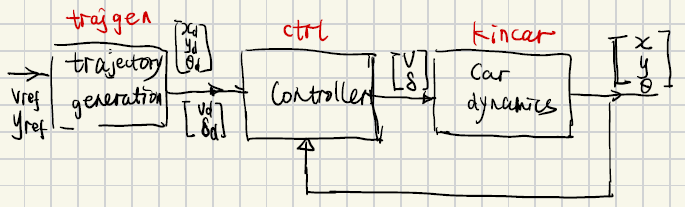

In [ ]:
# Create the closed loop system using create_statefbk_iosystem
# ctrl is the controller system, clsys is the closed loop system
ctrl, clsys = ctl.create_statefbk_iosystem(
    kincar, K,
    xd_labels=['xd', 'yd', 'thetad'],
    ud_labels=['vd', 'deltad'])
print(clsys)

<InterconnectedSystem>: kincar_sys[16]
Inputs (5): ['xd', 'yd', 'thetad', 'vd', 'deltad']
Outputs (5): ['x', 'y', 'theta', 'v', 'delta']
States (3): ['kincar_x', 'kincar_y', 'kincar_theta']

Subsystems (2):
 * <NonlinearIOSystem kincar: ['v', 'delta'] -> ['x', 'y', 'theta']>
 * <StateSpace sys[16]: ['xd', 'yd', 'thetad', 'vd', 'deltad', 'x', 'y',
    'theta'] -> ['v', 'delta']>

Connections:
 * kincar.v <- sys[16].v
 * kincar.delta <- sys[16].delta
 * sys[16].xd <- xd
 * sys[16].yd <- yd
 * sys[16].thetad <- thetad
 * sys[16].vd <- vd
 * sys[16].deltad <- deltad
 * sys[16].x <- kincar.x
 * sys[16].y <- kincar.y
 * sys[16].theta <- kincar.theta

Outputs:
 * x <- kincar.x
 * y <- kincar.y
 * theta <- kincar.theta
 * v <- sys[16].v
 * delta <- sys[16].delta


### Reference trajectory subsystem

We can create $x_\text{d}(t)$ and $u_\text{d}(t)$ corresponding to desired speed ($v_{ref}$) and lateral position ($y_{ref}$).
The reference trajectory block below generates a simple trajectory for the system given $v_{ref}$ and $y_{ref}$.  The trajectory consists of a straight line of the form
$$
x_\text{d}(t)=[v_{ref} t, \quad y_{ref}, \quad0]^T
$$
with nominal input
$$
u_\text{d}(t)
=[v_{ref},\quad 0]^T
$$

In [ ]:
# System state: none
# System input: vref, yref
# System output: xd, yd, thetad, vd, deltad
# System parameters: none

def trajgen_output(t, x, u, params):
    vref, yref = u
    return np.array([vref * t, yref, 0, vref, 0])

# Define the trajectory generator as an input/output system with no parameters or states
trajgen = ctl.nlsys(
    None, trajgen_output, name='trajgen',
    inputs=('vref', 'yref'),
    outputs=('xd', 'yd', 'thetad', 'vd', 'deltad'))

print(trajgen)

<NonlinearIOSystem>: trajgen
Inputs (2): ['vref', 'yref']
Outputs (5): ['xd', 'yd', 'thetad', 'vd', 'deltad']
States (0): []

Update: <function NonlinearIOSystem.__init__.<locals>.<lambda> at 0x77ff8de0bba0>
Output: <function trajgen_output at 0x77ff8de09c60>


### Step responses

To explore the dynamics of the system, we create a set of lane changes at different forward speeds.  Since the linearization depends on the speed, this means that the closed loop performance of the system will vary.

In [ ]:
steering_fixed = ctl.interconnect(
    [kincar, ctrl, trajgen],
    inputs=['vref', 'yref'],
    #specify the outputs of the interconnected system to be the kincar outputs and inputs
    outputs=kincar.output_labels + kincar.input_labels
)
print(steering_fixed)

<InterconnectedSystem>: sys[17]
Inputs (2): ['vref', 'yref']
Outputs (5): ['x', 'y', 'theta', 'v', 'delta']
States (3): ['kincar_x', 'kincar_y', 'kincar_theta']

Subsystems (3):
 * <NonlinearIOSystem kincar: ['v', 'delta'] -> ['x', 'y', 'theta']>
 * <StateSpace sys[16]: ['xd', 'yd', 'thetad', 'vd', 'deltad', 'x', 'y',
    'theta'] -> ['v', 'delta']>
 * <NonlinearIOSystem trajgen: ['vref', 'yref'] -> ['xd', 'yd', 'thetad',
    'vd', 'deltad']>

Connections:
 * kincar.v <- sys[16].v
 * kincar.delta <- sys[16].delta
 * sys[16].xd <- trajgen.xd
 * sys[16].yd <- trajgen.yd
 * sys[16].thetad <- trajgen.thetad
 * sys[16].vd <- trajgen.vd
 * sys[16].deltad <- trajgen.deltad
 * sys[16].x <- kincar.x
 * sys[16].y <- kincar.y
 * sys[16].theta <- kincar.theta
 * trajgen.vref <- vref
 * trajgen.yref <- yref

Outputs:
 * x <- kincar.x
 * y <- kincar.y
 * theta <- kincar.theta
 * v <- sys[16].v
 * delta <- sys[16].delta


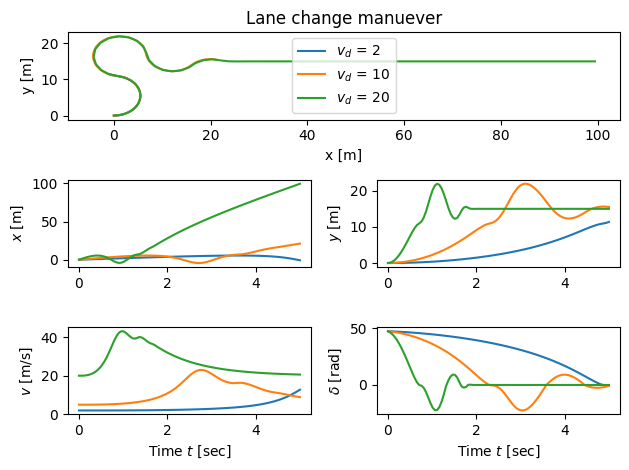

In [ ]:
# Set up the simulation conditions
yref = 15
T = np.linspace(0, 5, 100)

# Do an iteration through different speeds
for vref in [2, 5, 20]:
    # Simulate the closed loop controller response
    tout, yout = ctl.input_output_response(
        steering_fixed, T, [vref * np.ones(len(T)), yref * np.ones(len(T))],
        X0=[0, 0, 0], params={'maxsteer': 0.5})

    # Plot the results
    plot_lanechange(tout, yout, yout[3:])

# Label the different curves
plt.subplot(3, 1, 1)
plt.legend(["$v_d$ = " + f"{vref}" for vref in [2, 10, 20]])
plt.tight_layout()

Try to change the values of $y_{ref}$, you will see that the constant gain values will not be able to track the reference. Why is this?

## Task 2: Gain scheduled controller

Now let's design a gain scheduled controller for the system. We first linearize the system about the desired trajectory to obtain

$$
  \begin{aligned}
    A(x_\text{d}) &= \left. \frac{\partial f}{\partial x} \right|_{(x_\text{d}, u_\text{d})}
      = \begin{bmatrix}
          0 & 0 & -\sin\theta_\text{d}\, v_\text{d} \\ 0 & 0 & \cos\theta_\text{d}\, v_\text{d} \\ 0 & 0 & 0
        \end{bmatrix}. \\
    B(x_\text{d}) &= \left. \frac{\partial f}{\partial u} \right|_{(x_\text{d}, u_\text{d})}
     = \begin{bmatrix}
       1 & 0 \\ 0 & 0 \\ 0 & v_\text{d}/l
       \end{bmatrix}.
  \end{aligned}
$$
where
$$
x_\text{d}(t) = \begin{bmatrix} x_\text{d} \\ y_\text{d} \\ \theta_\text{d} \end{bmatrix}, \qquad
u_\text{d}(t) = \begin{bmatrix} v_\text{d} \\ \delta_\text{d} \end{bmatrix}
$$
We see that these matrices depend only on $\theta_\text{d}$ and $v_\text{d}$, so we choose these as the scheduling variables and design a controller of the form

$$
u = u_\text{d} - K(\mu) (x - x_\text{d})
$$

where $\mu = (\theta_\text{d}, v_\text{d})$ and we interpolate the gains based on LQR controllers computed at a fixed set of points $\mu_i$.

In [ ]:
# Define the points for the scheduling variables
gs_speeds = [2, 10, 20]
gs_angles = np.linspace(-pi, pi, 4) # generate 4 angles from -pi to pi for theta

# generate all combinations of speed and angle, how many combinations?
points = [np.array([speed, angle])
          for speed in gs_speeds
          for angle in gs_angles]
# Create controllers at each scheduling point
# Since the linearization depends on only speed and angle, we assume other states are zero
gains = [np.array(ctl.lqr(kincar.linearize([0, 0, angle], [speed, 0]), Qx, Qu)[0])
    for speed in gs_speeds
    for angle in gs_angles]
print(f"{points=}")
print(f"{gains=}")


# Create the gain scheduled system
# gainsched_method='linear' creates a linear interpolation of the gains between the points
ctrl_gs, _ = ctl.create_statefbk_iosystem(
    kincar, (gains, points), name='controller',
    xd_labels=['xd', 'yd', 'thetad'], ud_labels=['vd', 'deltad'],
    gainsched_indices=['vd', 'theta'], gainsched_method='linear')
print(ctrl_gs)

points=[array([ 2.        , -3.14159265]), array([ 2.        , -1.04719755]), array([2.        , 1.04719755]), array([2.        , 3.14159265]), array([10.        , -3.14159265]), array([10.        , -1.04719755]), array([10.        ,  1.04719755]), array([10.        ,  3.14159265]), array([20.        , -3.14159265]), array([20.        , -1.04719755]), array([20.        ,  1.04719755]), array([20.        ,  3.14159265])]
gains=[array([[-1.00000000e+00, -2.59398436e-07, -1.23043482e-07],
       [ 8.20289884e-08, -3.16227766e+00,  4.36734083e+00]]), array([[ 0.30513041, -3.01147046, -0.53921814],
       [ 0.95231058,  0.96490708,  2.76628217]]), array([[ 0.30513017,  3.0114707 ,  0.53921711],
       [-0.95231065,  0.96490633,  2.76628164]]), array([[-1.00000000e+00, -2.59398435e-07, -1.23043482e-07],
       [ 8.20289876e-08, -3.16227766e+00,  4.36734083e+00]]), array([[-1.00000000e+00, -4.35732785e-07, -4.13372414e-08],
       [ 1.37790805e-07, -3.16227766e+00,  4.36734083e+00]]), array([

### System construction

The input to the full closed loop system is the desired lateral position and the desired forward velocity.  The output for the system is taken as the full vehicle state plus the velocity of the vehicle.

We construct the system using the `ct.interconnect` function and use signal labels to keep track of everything.  

In [ ]:
steering_gainsched = ctl.interconnect(
    [trajgen, ctrl_gs, kincar], name='steering',
    inputs=['vref', 'yref'],
    outputs=kincar.output_labels + kincar.input_labels
)
print(steering_gainsched)

<InterconnectedSystem>: steering
Inputs (2): ['vref', 'yref']
Outputs (5): ['x', 'y', 'theta', 'v', 'delta']
States (3): ['kincar_x', 'kincar_y', 'kincar_theta']

Subsystems (3):
 * <NonlinearIOSystem trajgen: ['vref', 'yref'] -> ['xd', 'yd', 'thetad',
    'vd', 'deltad']>
 * <NonlinearIOSystem controller: ['xd', 'yd', 'thetad', 'vd', 'deltad', 'x',
    'y', 'theta'] -> ['v', 'delta']>
 * <NonlinearIOSystem kincar: ['v', 'delta'] -> ['x', 'y', 'theta']>

Connections:
 * trajgen.vref <- vref
 * trajgen.yref <- yref
 * controller.xd <- trajgen.xd
 * controller.yd <- trajgen.yd
 * controller.thetad <- trajgen.thetad
 * controller.vd <- trajgen.vd
 * controller.deltad <- trajgen.deltad
 * controller.x <- kincar.x
 * controller.y <- kincar.y
 * controller.theta <- kincar.theta
 * kincar.v <- controller.v
 * kincar.delta <- controller.delta

Outputs:
 * x <- kincar.x
 * y <- kincar.y
 * theta <- kincar.theta
 * v <- controller.v
 * delta <- controller.delta


### System simulation

We now simulate the gain scheduled controller for a step input in the $y$ position, using a range of vehicle speeds $v_\text{d}$:

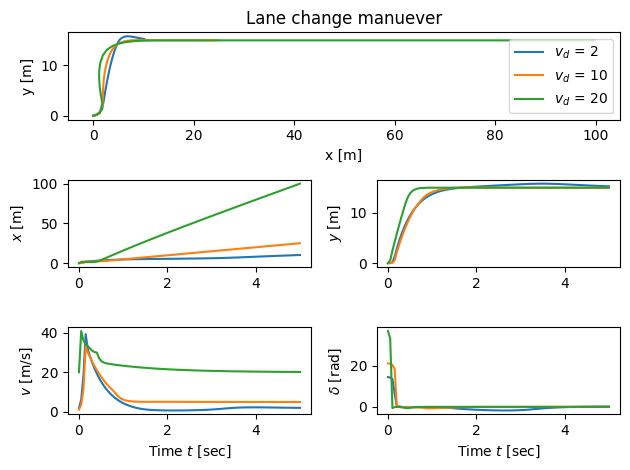

In [ ]:
# Plot the reference trajectory for the y position
# plt.plot([0, 5], [yref, yref], 'k-', linewidth=0.6)

# Find the signals we want to plot
y_index = steering_gainsched.find_output('y')
v_index = steering_gainsched.find_output('v')

# Do an iteration through different speeds
for vref in [2, 5, 20]:
    # Simulate the closed loop controller response
    tout, yout = ctl.input_output_response(
        steering_gainsched, T, [vref * np.ones(len(T)), yref * np.ones(len(T))],
        X0=[0, 0, 0], params={'maxsteer': 1}
    )

    # Plot the results
    plot_lanechange(tout, yout, yout[3:])

# Label the different curves
plt.subplot(3, 1, 1)
plt.legend(["$v_d$ = " + f"{vref}" for vref in [2, 10, 20]])
plt.tight_layout()

## HW problem

### Problem 1: Constant Gain Controller Variation Study  
In this problem, we will try to vary the `vref`, `yref` , and linearization point to investigate the performance of the constant gain controller.
   - Fix the forward speed `vref` (e.g., `vref = 10`) and vary the lateral reference `yref` (e.g., `yref = 5`, `yref = 40`, `yref = -10`).  Plot the vehicle trajectory and compare the tracking performance using the constant gain controller.  
   - Fix the lateral reference `yref` (e.g., `yref = 10`) and vary the forward speed `vref` (e.g., `vref = 8`, `vref = 15`).  Plot the vehicle trajectory and compare the tracking performance using the constant gain controller.  
   - Try changing the linearization point for the controller gain computation:  
     - `x_nom = np.array([0, 0, 0])`, `u_nom = np.array([5, 0])`, simulate the system for (1) `yref=5` and `vref=5`; (2) `yref=5` and `vref=20`
      - `x_nom = np.array([0, 0, -np.pi/4])`, `u_nom = np.array([20, 0])`, simulate the system for (1) `yref=5` and `vref=5`; (2) `yref=5` and `vref=20`  
   - Explain the results you have obtained in the previous three cases, especially why the linearization point matters for nonlinear systems.


### Problem 2. Gain-Scheduled Controller Comparison:  
- Repeat the above experiments using the gain-scheduled controller (see cell 21).  
- Compare the tracking results for different `yref` and `vref` values.  
- Explain why the gain-scheduled controller performs better across a wider range of operating conditions.

### Problem 3: Implement an analytical gain controller
In lectures, we derived an analytical gain-scheduled controller, where the feedback gain $K$ is a continuous function of the reference speed $v_r$. This approach is different from the gain-scheduled controller implemented in this lab, which uses interpolation between discrete LQR gains.

The analytical gain matrix is given by:
  $$
    K(x_d, u_d) =
    \begin{bmatrix}
    \lambda_1 & 0 & 0 \\
    0 & \dfrac{a_2 l}{v_r^2} & \dfrac{a_1 l}{v_r}
    \end{bmatrix}
  $$

**Tasks:**
- Implement this analytical gain-scheduled controller in your simulation, using $v_r$ as the reference speed (you may use $l = 3$ as in the lab).
- Choose and justify reasonable values for $\lambda_1$, $a_1$, and $a_2$.
- Simulate the closed-loop system using this controller for several values of $v_{ref}$ and $y_{ref}$.
- Compare the tracking performance of this controller with the gain-scheduled controller from Task 2 (which uses interpolated LQR gains).